## Import and cleaning the data

In [107]:
# Loading neccessary libraries
library(readr)
library(tidyverse)
library(dplyr)
library(caret)
library(broom.mixed)
library(doSNOW)

In [2]:
# Import the Census dataset and replace ',' ' ' as NA values and trim white space
sf_block <- read_csv('C:/Datasets/pdb_block_group.csv', col_names = T, col_types = NULL, na=c(""," "), trim_ws = T)

Parsed with column specification:
cols(
  .default = col_double(),
  State_name = col_character(),
  County_name = col_character(),
  Med_HHD_Inc_BG_ACS_09_13 = col_character(),
  Med_HHD_Inc_BG_ACSMOE_09_13 = col_character(),
  Med_HHD_Inc_TR_ACS_09_13 = col_character(),
  Med_HHD_Inc_TR_ACSMOE_09_13 = col_character(),
  Aggregate_HH_INC_ACS_09_13 = col_character(),
  Aggregate_HH_INC_ACSMOE_09_13 = col_character(),
  Med_House_Value_BG_ACS_09_13 = col_character(),
  Med_House_Value_BG_ACSMOE_09_13 = col_character(),
  Med_house_value_TR_ACS_09_13 = col_character(),
  Med_house_value_TR_ACSMOE_09_13 = col_character(),
  Aggr_House_Value_ACS_09_13 = col_character(),
  Aggr_House_Value_ACSMOE_09_13 = col_character(),
  avg_Agg_HH_INC_ACS_09_13 = col_character(),
  avg_Agg_HH_INC_ACSMOE_09_13 = col_character(),
  avg_Agg_House_Value_ACS_09_13 = col_character(),
  avg_Agg_House_Value_ACSMOE_09_13 = col_character()
)

See spec(...) for full column specifications.



In [3]:
# Overview of the dataset
head(sf_block)

FIPS_Block_Group,State,State_name,County,County_name,Tract,Block_Group,Flag,LAND_AREA,AIAN_LAND,...,pct_TEA_Update_Leave_CEN_2010,pct_Census_Mail_Returns_CEN_2010,pct_Vacant_CEN_2010,pct_Deletes_CEN_2010,pct_Census_UAA_CEN_2010,pct_Mailback_Count_CEN_2010,pct_FRST_FRMS_CEN_2010,pct_RPLCMNT_FRMS_CEN_2010,pct_BILQ_Mailout_count_CEN_2010,has_superfund
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10010201001,1,Alabama,1,Autauga County,20100,1,NA,1.638,0,...,0,62.13,3.65,0,19.93,76.41,54.49,7.64,0,0
10010201002,1,Alabama,1,Autauga County,20100,2,NA,2.150,0,...,0,72.08,0.83,0,14.17,85.00,66.46,5.63,0,0
10010202001,1,Alabama,1,Autauga County,20200,1,NA,0.795,0,...,0,69.21,2.11,0,11.58,86.32,62.63,6.58,0,0
10010202002,1,Alabama,1,Autauga County,20200,2,NA,0.495,0,...,0,68.50,2.42,0,14.32,83.26,59.25,9.25,0,0
10010203001,1,Alabama,1,Autauga County,20300,1,NA,1.493,0,...,0,75.16,1.57,0,5.24,93.19,75.16,0.00,0,0
10010203002,1,Alabama,1,Autauga County,20300,2,NA,0.572,0,...,0,67.13,1.93,0,9.94,88.12,67.13,0.00,0,0


#### Drop columns that are not useful for prediction and covert currency columns to numeric

In [4]:
# MOE is margin of error is columsn that contain confidence level of ACS survey, we only need the main estimate so we drop these
sf_block <- sf_block %>% select(-contains('MOE'))

In [5]:
# We again drop block id, and other states, counties names and keep only useful covariates
sf_block <- sf_block %>% select(-c('FIPS_Block_Group','State','State_name','County','County_name','Tract','Block_Group','Flag'))

In [6]:
# Convert currency to numeric
sf_block$Med_HHD_Inc_BG_ACS_09_13 <- parse_number(gsub("\\$","",sf_block$Med_HHD_Inc_BG_ACS_09_13))
sf_block$Med_HHD_Inc_TR_ACS_09_13 <- parse_number(gsub("\\$","",sf_block$Med_HHD_Inc_TR_ACS_09_13))
sf_block$Aggregate_HH_INC_ACS_09_13 <- parse_number(gsub("\\$","",sf_block$Aggregate_HH_INC_ACS_09_13))
sf_block$Med_House_Value_BG_ACS_09_13 <- parse_number(gsub("\\$","",sf_block$Med_House_Value_BG_ACS_09_13))
sf_block$Med_house_value_TR_ACS_09_13 <- parse_number(gsub("\\$","",sf_block$Med_house_value_TR_ACS_09_13))
sf_block$Aggr_House_Value_ACS_09_13 <- parse_number(gsub("\\$","",sf_block$Aggr_House_Value_ACS_09_13))
sf_block$avg_Agg_HH_INC_ACS_09_13 <- parse_number(gsub("\\$","",sf_block$avg_Agg_HH_INC_ACS_09_13))
sf_block$avg_Agg_House_Value_ACS_09_13 <- parse_number(gsub("\\$","",sf_block$avg_Agg_House_Value_ACS_09_13))

In [7]:
# Convert target variable 'has_superfund' into factor
sf_block$has_superfund <- as.factor(sf_block$has_superfund)
levels(sf_block$has_superfund) <- c('No', 'Yes')

#### Drop highly correlated columns and deal with NA values

In [8]:
# In the Census and American Community Survey, there are many variables that are highly correlated with each other such as
# total race vs its composition races in a census block; so we will drop these highly correlated columns
correlat <- cor(sf_block[, -217], use="pairwise.complete.obs")
findCorrelation(correlat, cutoff=0.7, verbose=FALSE)

[1]   6   7   9  10  11  14  18  19  28  41  42  43  46  48  49  51  57  58
 [19]  59  60  61  70  71  72  73  74  75  76  80  81  82  83  84  86  87  88
 [37]  89  90 102 105 109 110 115 118 135 136 137 144 145 152 153 161 168 169
 [55] 171 172 173 174 177 178 179 181 182 183 184 185 186 189 190 191 192 193
 [73] 196 204 206 207 208 209 210 211 213 214 216   8  12  16  20  22  17  24
 [91]  29  31  33  35  37  27  62  64  63  66  67  68  15  78  21  99  45 112
[109]   4 119 120 127 129 133 138 140  32 142  36 146  38  39  40  44  47 134
[127]  50  53 139  54  55  56  65 175 170  77  79 101 194 195 197  92  93 198
[145]  94  95  96  98 108 111

In [9]:
# Deselect the above columns
sf_block <- sf_block %>% select(-c(6,7,9,10,11,14,18,19,28,41,42,43,46,48,49,51,57,58,59,60,61,70,71,72,73,74,75,76,80,81,82,83,84,86,87,88,89,90,102,105,109,110,115,118,135,136,137,144,145,152,153,161,168,169,171,172,173,174,177,178,179,181,182,183,184,185,186,189,190,191,192,193,196,204,206,207,208,209,210,211,213,214,216,8,12,16,20,22,17,24,29,31,33,35,37,27,62,64,63,66,67,68,15,78,21,99,45,112,4,119,120,127,129,133,138,140,32,142,36,146,38,39,40,44,47,134,50,53,139,54,55,56,65,175,170,77,79,101,194,195,197,92,93,198,94,95,96,98,108,111))

In [10]:
# Overview of the dataset again
summary(sf_block)

   LAND_AREA          AIAN_LAND       URBANIZED_AREA_POP_CEN_2010
 Min.   :    0.00   Min.   :0.00000   Min.   :    0              
 1st Qu.:    0.19   1st Qu.:0.00000   1st Qu.:    0              
 Median :    0.50   Median :0.00000   Median :  960              
 Mean   :   16.05   Mean   :0.02205   Mean   : 1013              
 3rd Qu.:    3.36   3rd Qu.:0.00000   3rd Qu.: 1508              
 Max.   :61079.28   Max.   :1.00000   Max.   :31777              
 NA's   :20         NA's   :20        NA's   :20                 
 RURAL_POP_CEN_2010 Pop_under_5_ACS_09_13 Pop_65plus_ACS_09_13
 Min.   :   0.0     Min.   :   0.00       Min.   :    0.0     
 1st Qu.:   0.0     1st Qu.:  34.00       1st Qu.:   98.0     
 Median :   0.0     Median :  70.00       Median :  162.0     
 Mean   : 271.1     Mean   :  91.98       Mean   :  192.5     
 3rd Qu.: 230.0     3rd Qu.: 123.00       3rd Qu.:  248.0     
 Max.   :8126.0     Max.   :6607.00       Max.   :20842.0     
 NA's   :20         NA's   :21 

We see that there is NA in every columns and we have more two hundred thousand samples hence let's use only rows with complete data

In [11]:
# Retain complete cases of 
sf_block_completed <- sf_block[complete.cases(sf_block),]

In [12]:
# Is there missing data left?
sum(is.na(sf_block_completed))

[1] 0

In [13]:
# Overview structure of the dataset
str(sf_block_completed)

Classes 'tbl_df', 'tbl' and 'data.frame':	213089 obs. of  67 variables:
 $ LAND_AREA                      : num  1.638 2.15 0.795 0.495 1.493 ...
 $ AIAN_LAND                      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ URBANIZED_AREA_POP_CEN_2010    : num  524 1070 1003 1167 2549 ...
 $ RURAL_POP_CEN_2010             : num  174 144 0 0 0 0 0 0 0 0 ...
 $ Pop_under_5_ACS_09_13          : num  22 59 97 5 94 29 61 34 46 7 ...
 $ Pop_65plus_ACS_09_13           : num  14 143 98 131 308 132 225 384 195 135 ...
 $ Inst_GQ_CEN_2010               : num  0 0 0 181 0 0 0 0 0 0 ...
 $ Non_Inst_GQ_CEN_2010           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ NH_White_alone_ACS_09_13       : num  552 1024 419 357 1802 ...
 $ NH_AIAN_alone_ACS_09_13        : num  0 10 0 0 15 0 22 0 0 0 ...
 $ Diff_HU_1yr_Ago_ACS_09_13      : num  38 132 140 238 299 129 138 142 108 85 ...
 $ Sngl_Prns_HHD_ACS_09_13        : num  28 94 137 180 218 142 96 162 148 123 ...
 $ Tot_Vacant_Units_CEN_2010      : num  21 38 34 45 48 22 18 2

We go from 220,335 observations and retain complete cases of 213,089. In other words, we use 97% of the original dataset

In [14]:
# Let's back up this clean data
write.csv(sf_block_completed, 'C:/Datasets/sf_block_completed.csv')

## Data Splitting and Class Imbalance

In [15]:
# Create partition rule for splitting the dataset
partitionRule <- createDataPartition(sf_block_completed$has_superfund, p=0.7, list=F)

In [16]:
# Create imbalance training set and testing set
imtrainingSet <- sf_block_completed[partitionRule,]
testingSet <- sf_block_completed[-partitionRule,]

In [17]:
# Let's see how imbalance our dataset is
length(which(imtrainingSet$has_superfund=='Yes'))
length(which(imtrainingSet$has_superfund=='No'))

[1] 834

[1] 148329

In [18]:
# Using downSample function of caret, we will create a balance class training dataset
trainingSet <- downSample(x=imtrainingSet[,-67], y=imtrainingSet$has_superfund)

In [19]:
# Let's see how balance our dataset is
length(which(trainingSet$Class=='Yes'))
length(which(trainingSet$Class=='No'))

[1] 834

[1] 834

## Model Training

In [73]:
# Let's create training parameters used for caret train control
mycontrol <- trainControl(method='repeatedcv', number=10, repeats=3, search='grid',
                                  summaryFunction=twoClassSummary,
                                  classProbs = TRUE,
                                  savePredictions = TRUE)

#### Setup parallel computing

In [21]:
# Create a socket cluster using 10 processes.
cl <- makeCluster(10, type = "SOCK")

# Register cluster so that caret will know to train in parallel.
registerDoSNOW(cl)

#### Classification with a baseline Logistic Regression

In [74]:
# Training model with Logistic Regression
LRModel <- train(Class ~ ., data=trainingSet,
                trControl = mycontrol,
                metric = 'ROC',
                method = 'glm', family = 'binomial')

In [75]:
# Using the model to predict classification of test set
LRPredictions <- predict(LRModel, testingSet)

In [76]:
# Create confusion matrix
cmLR <- confusionMatrix(LRPredictions, testingSet$has_superfund)
print(cmLR)

Confusion Matrix and Statistics

          Reference
Prediction    No   Yes
       No  37154   146
       Yes 26415   211
                                          
               Accuracy : 0.5845          
                 95% CI : (0.5807, 0.5883)
    No Information Rate : 0.9944          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0047          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.584467        
            Specificity : 0.591036        
         Pos Pred Value : 0.996086        
         Neg Pred Value : 0.007925        
             Prevalence : 0.994415        
         Detection Rate : 0.581203        
   Detection Prevalence : 0.583487        
      Balanced Accuracy : 0.587752        
                                          
       'Positive' Class : No              
                  

In [25]:
# Select significant variable with p-value<=0.05
logitmod <- glm(Class~., family = 'binomial', data = trainingSet)
logitmod_tm = tidy(logitmod)
logitmod_tm$term[logitmod_tm$p.value<=0.05]

[1] "AIAN_LAND"                     "Pop_65plus_ACS_09_13"         
 [3] "Sngl_Prns_HHD_ACS_09_13"       "pct_Pop_45_64_CEN_2010"       
 [5] "pct_NH_White_alone_ACS_09_13"  "pct_NH_Asian_alone_ACS_09_13" 
 [7] "pct_College_ACS_09_13"         "pct_One_Health_Ins_ACS_09_13" 
 [9] "pct_TwoPHealth_Ins_ACS_09_13"  "pct_No_Health_Ins_ACS_09_13"  
[11] "pct_Recent_Built_HU_ACS_09_13"

#### Classification with Linear SVM

In [77]:
# Training model with Linear SVM
LSVModel <- train(Class ~ ., data=trainingSet,
                 method = 'svmLinear',
                 metric = 'ROC',
                 trControl = mycontrol,
                 preProcess = c('center', 'scale'),
                 tuneLength = 10)

In [78]:
# Using the model to predict classification of test set
LSVMPredictions <- predict(LSVModel, testingSet)

In [79]:
# Create confusion matrix
cmLSVM <- confusionMatrix(LSVMPredictions, testingSet$has_superfund)
print(cmLSVM)

Confusion Matrix and Statistics

          Reference
Prediction    No   Yes
       No  37387   146
       Yes 26182   211
                                         
               Accuracy : 0.5881         
                 95% CI : (0.5843, 0.592)
    No Information Rate : 0.9944         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.0048         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.588133       
            Specificity : 0.591036       
         Pos Pred Value : 0.996110       
         Neg Pred Value : 0.007995       
             Prevalence : 0.994415       
         Detection Rate : 0.584848       
   Detection Prevalence : 0.587132       
      Balanced Accuracy : 0.589584       
                                         
       'Positive' Class : No             
                                      

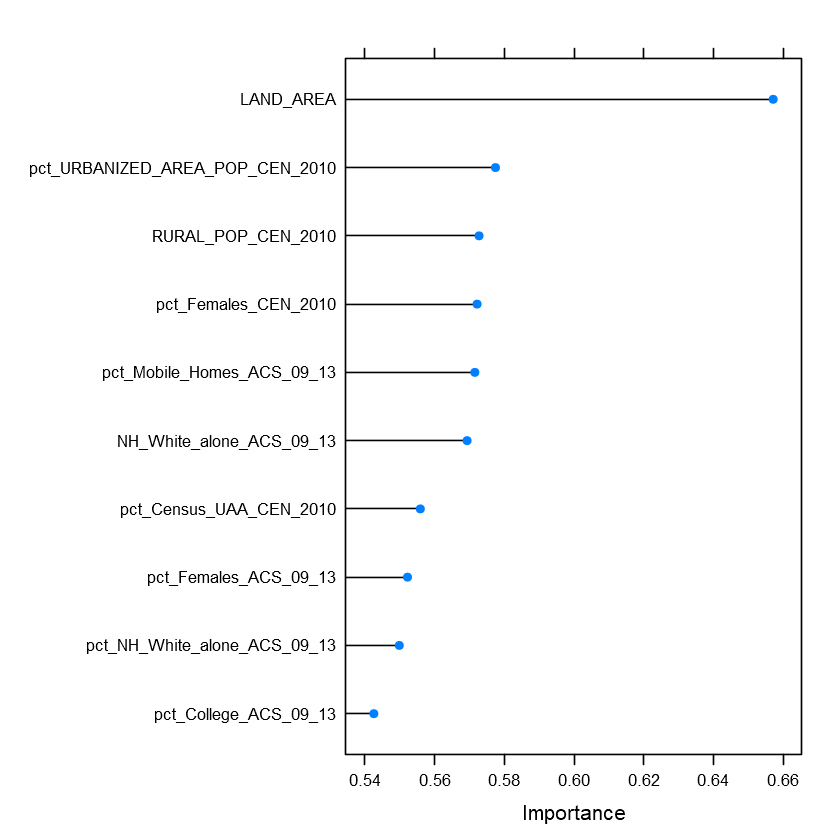

In [80]:
# Ranking features by importance
LSVM_importance <- varImp(LSVModel, scale=FALSE)
plot(LSVM_importance, top = 10)

#### Classification with Non-linear Support Vector Machine

In [81]:
# Training model with SVM
SVModel <- train(Class ~ ., data=trainingSet,
                method = 'svmRadial',
                metric = 'ROC',
                trControl = mycontrol,
                preProcess = c('center', 'scale'))

In [82]:
# Using the model to predict classification of test set
SVMPredictions <- predict(SVModel, testingSet)

In [83]:
# Create confusion matrix
cmSVM <- confusionMatrix(SVMPredictions, testingSet$has_superfund)
print(cmSVM)

Confusion Matrix and Statistics

          Reference
Prediction    No   Yes
       No  37422   133
       Yes 26147   224
                                          
               Accuracy : 0.5889          
                 95% CI : (0.5851, 0.5927)
    No Information Rate : 0.9944          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0058          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.588683        
            Specificity : 0.627451        
         Pos Pred Value : 0.996459        
         Neg Pred Value : 0.008494        
             Prevalence : 0.994415        
         Detection Rate : 0.585396        
   Detection Prevalence : 0.587476        
      Balanced Accuracy : 0.608067        
                                          
       'Positive' Class : No              
                  

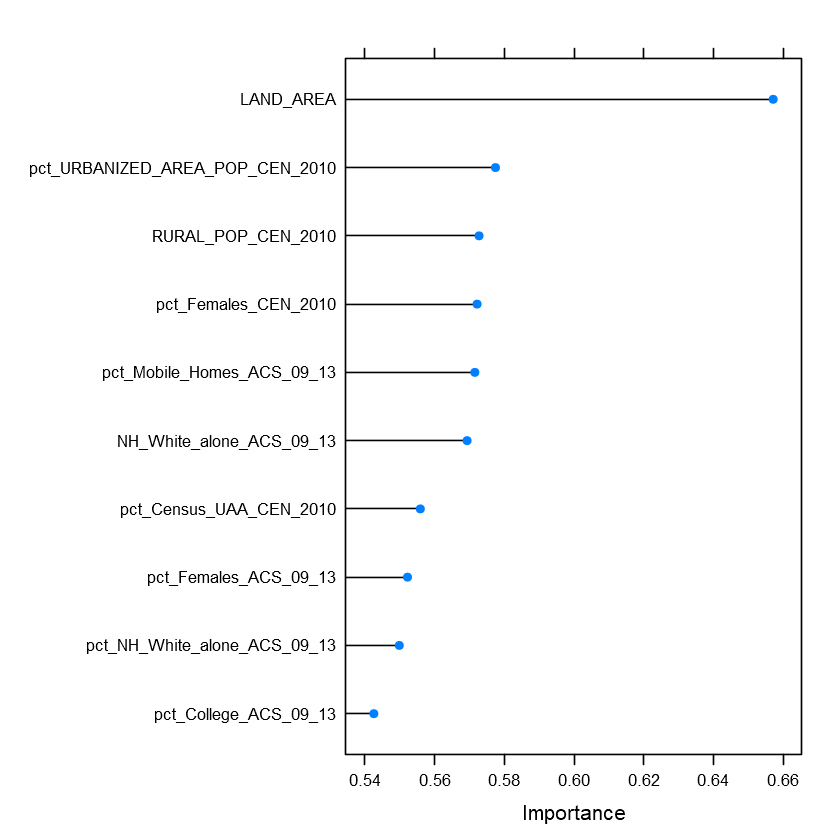

In [84]:
# Ranking features by importance
SVM_importance <- varImp(SVModel, scale=FALSE)
plot(SVM_importance, top = 10)

#### Classification with glmnet

In [85]:
# Training the model with glmnet
glmnetModel <- train(Class ~ ., data=trainingSet,
                    metric = 'ROC', method = 'glmnet',
                    tuneGrid = expand.grid(alpha = 0:1, lambda = 0:10/10),
                    trControl = mycontrol)

In [86]:
# Using the model to predict classification of test set
glmnetPredictions <- predict(glmnetModel, testingSet)

In [87]:
# Create confusion matrix
cmglmnet <- confusionMatrix(glmnetPredictions, testingSet$has_superfund)
print(cmglmnet)

Confusion Matrix and Statistics

          Reference
Prediction    No   Yes
       No  38536   156
       Yes 25033   201
                                          
               Accuracy : 0.606           
                 95% CI : (0.6022, 0.6098)
    No Information Rate : 0.9944          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0047          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.606207        
            Specificity : 0.563025        
         Pos Pred Value : 0.995968        
         Neg Pred Value : 0.007965        
             Prevalence : 0.994415        
         Detection Rate : 0.602822        
   Detection Prevalence : 0.605262        
      Balanced Accuracy : 0.584616        
                                          
       'Positive' Class : No              
                  

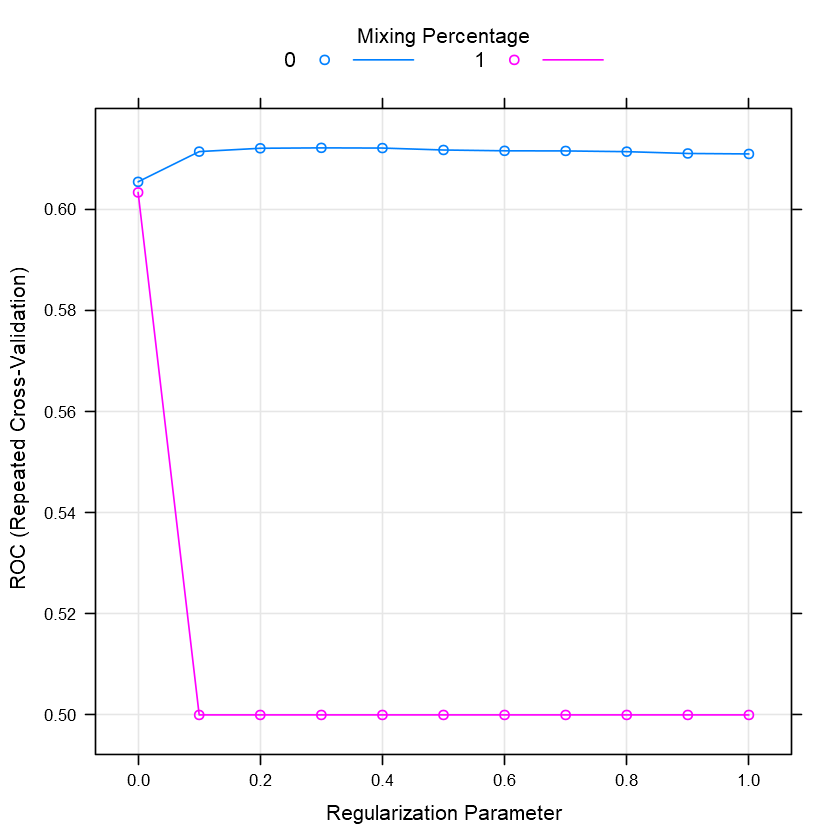

In [88]:
plot(GlmnetModel)

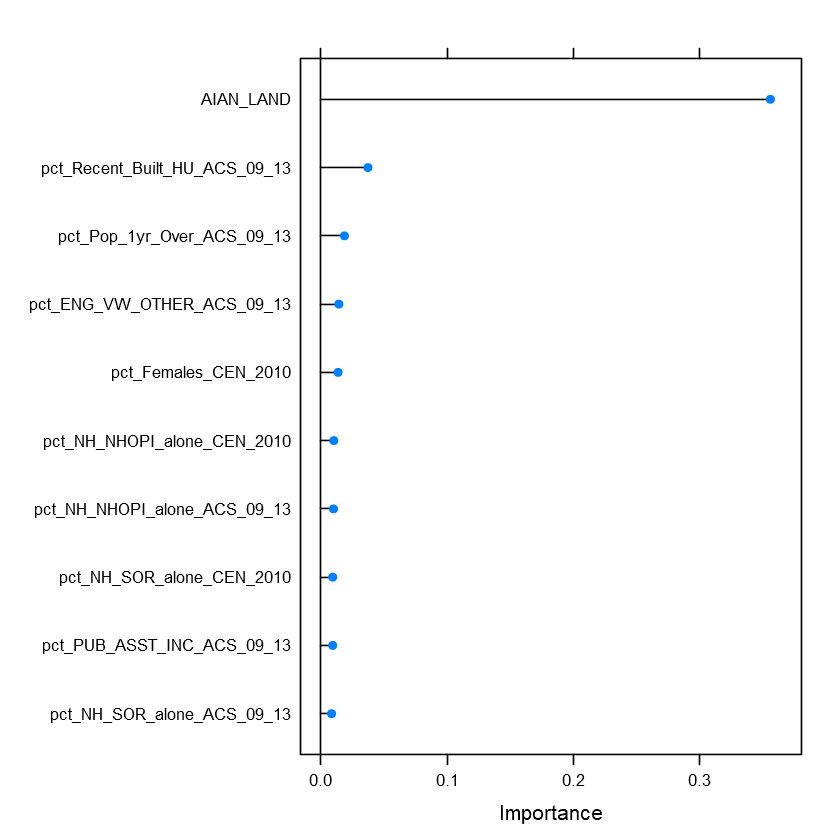

In [89]:
# Ranking features by importance
Glmnet_importance <- varImp(GlmnetModel, scale=FALSE)
plot(Glmnet_importance, top = 10)

#### Classification with Random Forest

In [90]:
# Training model with RF
RFModel <- train(Class ~ ., data=trainingSet,
                method = 'ranger',
                metric = 'ROC',
                trControl = mycontrol)

In [91]:
# Using the model to predict classification of test set
RFPredictions <- predict(RFModel, testingSet)

In [92]:
# Create confusion matrix
cmRF <- confusionMatrix(RFPredictions, testingSet$has_superfund)
print(cmRF)

Confusion Matrix and Statistics

          Reference
Prediction    No   Yes
       No  39272   105
       Yes 24297   252
                                         
               Accuracy : 0.6183         
                 95% CI : (0.6145, 0.622)
    No Information Rate : 0.9944         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.0093         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.61779        
            Specificity : 0.70588        
         Pos Pred Value : 0.99733        
         Neg Pred Value : 0.01027        
             Prevalence : 0.99442        
         Detection Rate : 0.61434        
   Detection Prevalence : 0.61598        
      Balanced Accuracy : 0.66183        
                                         
       'Positive' Class : No             
                                      

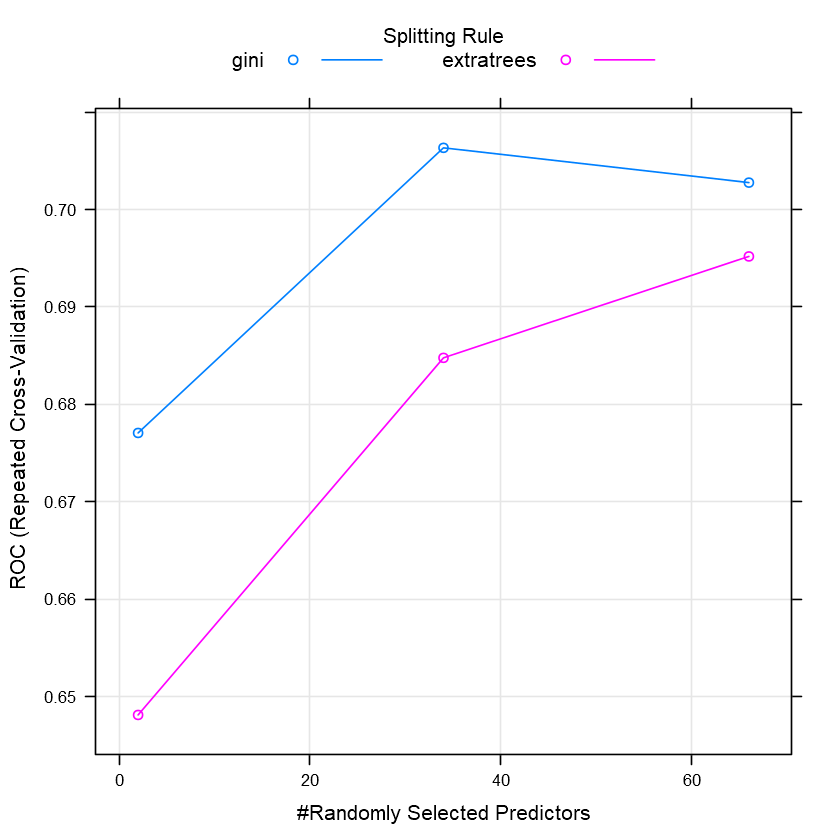

In [93]:
plot(RFModel)

#### Classification with XGBoost

In [59]:
# Create tuning grid for XGBoost
tune.grid <- expand.grid(eta = c(0.05, 0.075, 0.1),
                         nrounds = c(50, 75, 100),
                         max_depth = 6:8,
                         min_child_weight = c(2.0, 2.25, 2.5),
                         colsample_bytree = c(0.3, 0.4, 0.5),
                         gamma = 0,
                         subsample = 1)

In [100]:
# Train the xgboost model using 10-fold CV repeated 3 times and a hyperparameter grid search to train the optimal model.
xgbModel <- train(Class ~ ., 
                  data = trainingSet,
                  method = "xgbTree",
                  metric = 'ROC',
                  tuneGrid = tune.grid,
                  trControl = mycontrol)

In [101]:
# Using the model to predict classification of test set
xgbPredictions <- predict(xgbModel, testingSet)

In [102]:
# Create confusion matrix
cm_xgb <- confusionMatrix(xgbPredictions, testingSet$has_superfund)
print(cm_xgb)

Confusion Matrix and Statistics

          Reference
Prediction    No   Yes
       No  39492   109
       Yes 24077   248
                                          
               Accuracy : 0.6217          
                 95% CI : (0.6179, 0.6254)
    No Information Rate : 0.9944          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0092          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.6212          
            Specificity : 0.6947          
         Pos Pred Value : 0.9972          
         Neg Pred Value : 0.0102          
             Prevalence : 0.9944          
         Detection Rate : 0.6178          
   Detection Prevalence : 0.6195          
      Balanced Accuracy : 0.6580          
                                          
       'Positive' Class : No              
                  

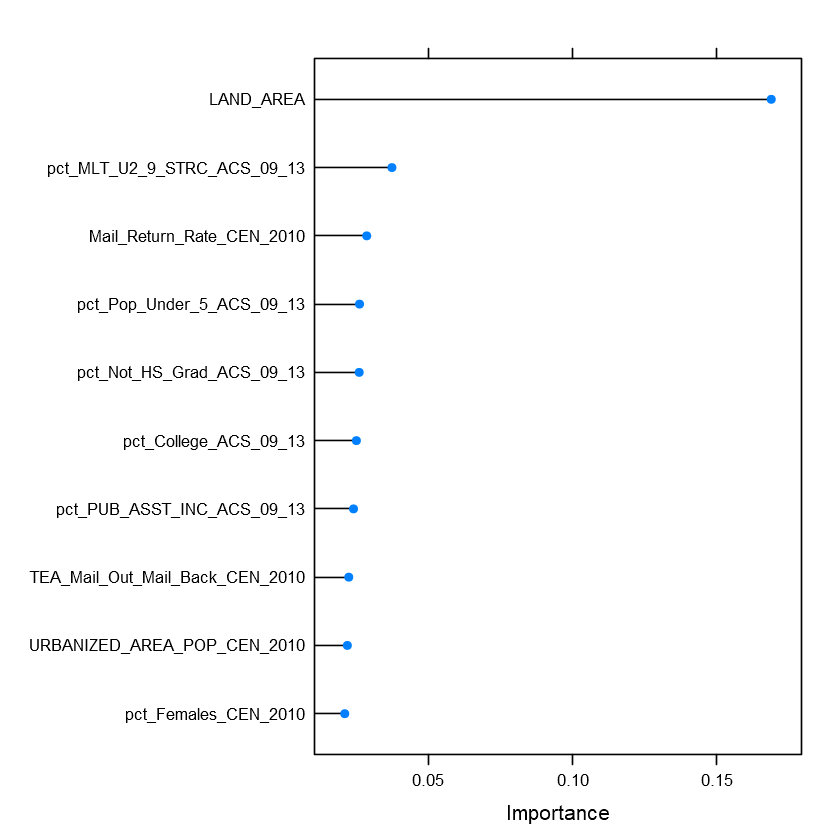

In [103]:
# Ranking features by importance
xgb_importance <- varImp(xgbModel, scale=FALSE)
plot(xgb_importance, top = 10)

#### Comparision among Ensemble Models

In [104]:
model_list <- list(lsvm = LRModel, svm = SVModel, glmnet = glmnetModel, rf = RFModel, xgb = xgbModel)

In [105]:
resamps <- resamples(model_list)
summary(resamps)


Call:
summary.resamples(object = resamps)

Models: lsvm, svm, glmnet, rf, xgb 
Number of resamples: 30 

ROC 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
lsvm   0.5484105 0.5855034 0.6047899 0.6045672 0.6175752 0.6846655    0
svm    0.5765921 0.6188826 0.6381205 0.6425634 0.6662769 0.7274814    0
glmnet 0.5283786 0.5923133 0.6137303 0.6097411 0.6392355 0.6784729    0
rf     0.6359414 0.6869168 0.7031262 0.7063345 0.7243797 0.7665663    0
xgb    0.6181870 0.6824082 0.7082366 0.7020727 0.7292660 0.7598967    0

Sens 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
lsvm   0.4819277 0.5435313 0.5722892 0.5782415 0.6071429 0.6904762    0
svm    0.5301205 0.5783133 0.6144578 0.6086489 0.6428571 0.6867470    0
glmnet 0.5060241 0.5612091 0.5952381 0.5998948 0.6385542 0.6987952    0
rf     0.4939759 0.5795683 0.6011905 0.5990295 0.6279762 0.6987952    0
xgb    0.5238095 0.5731497 0.6265060 0.6171256 0.6537220 0.7108434    0

Spec 
           

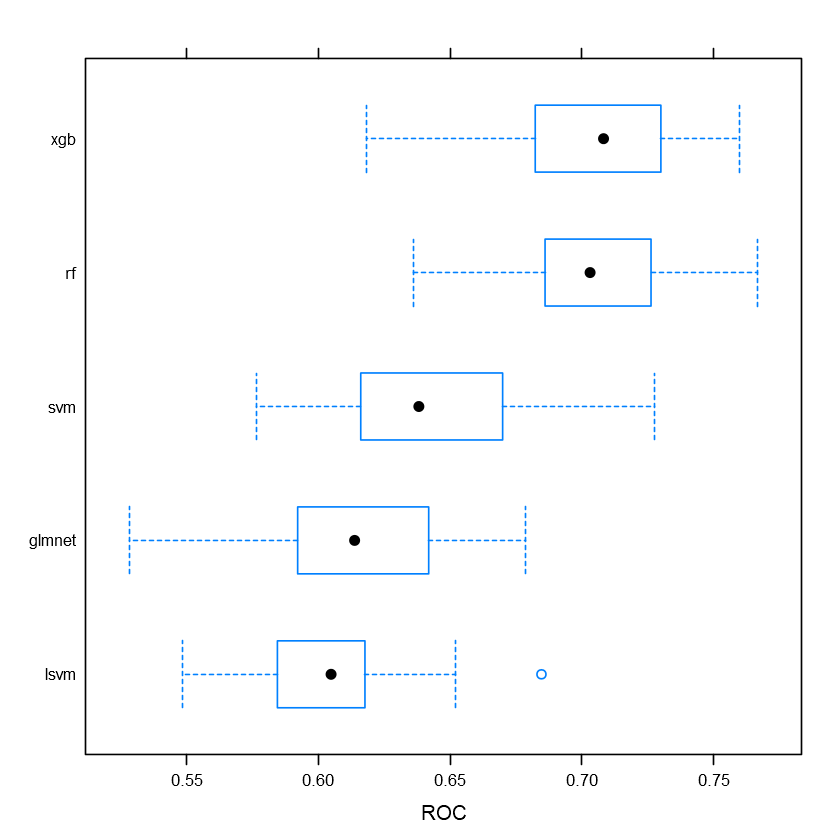

In [106]:
bwplot(resamps, metric = 'ROC')

We can see that XGBoost and Random Forest have better performance than other models but with much more operation cost